
# POS tagging using modified Viterbi

### Problem Statement:

We have learnt to build your own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

In this program, we will modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

### Data Preparation

In [54]:
## Importing libraries
import nltk
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [55]:
## Download NLTK
nltk.download('treebank')
nltk.download('universal_tagset')
  

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [56]:
## Read the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [57]:
## Print first few tagged sentences
print(nltk_data[:100])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [58]:

## Split the dataset into train 95% and test 5%. 
## Keeping the test datasize small, else the algorithm will need a very high amount of runtime.

from sklearn.model_selection import train_test_split
import random

random.seed(42)

train_set, test_set = train_test_split(nltk_data, train_size= 0.95,test_size= 0.05, random_state=42)

## Print number of rows in Train and Test dataset
len(train_set)
len(test_set)

3718

196

### Build the vanilla Viterbi based POS tagger

#### 1. Extract the Sentences and Words & tags from the train dataset 

In [59]:
## Extract the word & tag pairs in train_tagged_words
train_tagged_words = []
for sent in train_set:
    for tup in sent :
        train_tagged_words.append(tup) 

In [60]:
## Print the first few records of Word and tag pair
train_tagged_words[0:100]
len(train_tagged_words)

[('Bank', 'NOUN'),
 ('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('New', 'NOUN'),
 ('York', 'NOUN'),
 ('Stock', 'NOUN'),
 ('Exchange', 'NOUN'),
 ('.', '.'),
 ('$', '.'),
 ('130', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('of', 'ADP'),
 ('general', 'ADJ'),
 ('obligation', 'NOUN'),
 ('distributable', 'ADJ'),
 ('state', 'NOUN'),
 ('aid', 'NOUN'),
 ('bonds', 'NOUN'),
 ('due', 'ADJ'),
 ('1991-2000', 'NUM'),
 ('and', 'CONJ'),
 ('2009', 'NUM'),
 (',', '.'),
 ('tentatively', 'ADV'),
 ('priced', 'VERB'),
 ('*', 'X'),
 ('by', 'ADP'),
 ('a', 'DET'),
 ('Chemical', 'NOUN'),
 ('Securities', 'NOUN'),
 ('Inc.', 'NOUN'),
 ('group', 'NOUN'),
 ('*', 'X'),
 ('to', 'PRT'),
 ('yield', 'VERB'),
 ('from', 'ADP'),
 ('6.20', 'NUM'),
 ('%', 'NOUN'),
 ('in', 'ADP'),
 ('1991', 'NUM'),
 ('to', 'PRT'),
 ('7.272', 'NUM'),
 ('%', 'NOUN'),
 ('in', 'ADP'),
 ('2009', 'NUM'),
 ('.', '.

95589

In [61]:
## Extract only Words from word-tag pair
tokens = []
for pair in train_tagged_words:
    tokens.append(pair[0])

In [62]:
## Print first few words and number of words
tokens[0:40]
len(tokens)

['Bank',
 'of',
 'New',
 'England',
 "'s",
 'shares',
 'are',
 'traded',
 '*-1',
 'on',
 'the',
 'New',
 'York',
 'Stock',
 'Exchange',
 '.',
 '$',
 '130',
 'million',
 '*U*',
 'of',
 'general',
 'obligation',
 'distributable',
 'state',
 'aid',
 'bonds',
 'due',
 '1991-2000',
 'and',
 '2009',
 ',',
 'tentatively',
 'priced',
 '*',
 'by',
 'a',
 'Chemical',
 'Securities',
 'Inc.']

95589

In [63]:
## Vocabulary - Get Unqiue set of words
V = set(tokens)
len(V)

12109

In [64]:
## Extract Tags from word-tag pair
T = []
for pair in train_tagged_words:
    T.append(pair[1])
    
len(T)

95589

In [65]:
## Get Unique set of Tags
T = set(T)
len(T)

12

Theare are total **12 Unique tags** as below:

In [66]:
## Print the Unique tags in Train corpus
print(T)

{'.', 'NOUN', 'X', 'DET', 'ADJ', 'VERB', 'CONJ', 'NUM', 'ADV', 'PRT', 'ADP', 'PRON'}


#### 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t2/t1), we have to compute P(w/t) and P(t2/t1).

 - P(w/t) = Probability of Word w given tag t= `Emission Probability`
 - P(t2/t1) = Probability of tag t2 given previous tag t1 = `Transition probability`


#### Calculate Emission probabilities

In [67]:
## Compute probability of 'word given tag': Emission Probability

## Function name: word_given_tag
##      Input parameters: 'word' , 'tag'
##      Returns : count_w_given_tag (number of times the term 'word' has been tagged as tag 'tag')
##              : count_tag (number of times the tag 'tag' appeared in the corpus train dataset )

def word_given_tag(word, tag, train_bag = train_tagged_words):
    
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [68]:
## See results for an example:

print("bright")
word_given_tag('bright', 'ADJ')
word_given_tag('bright', 'NOUN')
word_given_tag('bright', 'VERB')

bright


(2, 6077)

(0, 27423)

(0, 12885)

#### Calculate Transition probabilities

In [69]:
# Compute probability of 'tag given previous tag': tag2(t2) given tag1 (t1), i.e. Transition Probability

## Function name: t2_given_t1
##      Input parameters: 't2' , 't1'
##      Returns : count_t2_t1 ( number of times the tag 't1' is followed by tag 't2')
##              : count_t1 (number of times the tag 't1' appeared in the corpus train dataset )

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
            
    return (count_t2_t1, count_t1)

In [70]:
## Example - ADJ Followed by NOUN
t2_given_t1('NOUN', 'ADJ')


(4234, 6077)

In [71]:
## Examples - tags SET, VERB, NOUN, ADJ as Start tag of sentence.
## Please note P(tag|start) is same as P(tag|'.')

print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('ADJ', '.'))

(1929, 11118)
(984, 11118)
(2481, 11118)
(500, 11118)


In [72]:
# Create t x t 'transition probability' matrix of tags
# Each column is t2 (current tag), each row is t1 (previous tag)
# Matrix(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [73]:
## Print tags transition probability matrix
tags_matrix

array([[9.38118398e-02, 2.23151639e-01, 2.66234931e-02, 1.73502430e-01,
        4.49721180e-02, 8.85051265e-02, 5.79240881e-02, 8.05000886e-02,
        5.20777106e-02, 2.33855005e-03, 9.11135077e-02, 6.53894618e-02],
       [2.39178792e-01, 2.64631867e-01, 2.91361269e-02, 1.33099956e-02,
        1.22889541e-02, 1.47977978e-01, 4.19356003e-02, 9.62695573e-03,
        1.68836378e-02, 4.38318215e-02, 1.76275387e-01, 4.92287474e-03],
       [1.63798600e-01, 6.13448061e-02, 7.64818341e-02, 5.51306568e-02,
        1.65710635e-02, 2.03632891e-01, 1.03569152e-02, 2.70873168e-03,
        2.51752716e-02, 1.85787126e-01, 1.42925426e-01, 5.60866781e-02],
       [1.79864801e-02, 6.40028954e-01, 4.55094166e-02, 5.31144394e-03,
        2.04973444e-01, 3.83872539e-02, 4.82858537e-04, 2.19700634e-02,
        1.23128919e-02, 2.41429268e-04, 9.05359723e-03, 3.74215352e-03],
       [6.53282851e-02, 6.96725368e-01, 2.13921349e-02, 5.10120112e-03,
        6.66447282e-02, 1.23416157e-02, 1.69491526e-02, 2.04

In [74]:
# Convert the matrix to a dataframe for better readability

tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [75]:
tags_df

,.,NOUN,X,DET,ADJ,VERB,CONJ,NUM,ADV,PRT,ADP,PRON
.,0.093812,0.223152,0.026623,0.173502,0.044972,0.088505,0.057924,0.080500,0.052078,0.002339,0.091114,0.065389
NOUN,0.239179,0.264632,0.029136,0.013310,0.012289,0.147978,0.041936,0.009627,0.016884,0.043832,0.176275,0.004923
X,0.163799,0.061345,0.076482,0.055131,0.016571,0.203633,0.010357,0.002709,0.025175,0.185787,0.142925,0.056087
DET,0.017986,0.640029,0.045509,0.005311,0.204973,0.038387,0.000483,0.021970,0.012313,0.000241,0.009054,0.003742
ADJ,0.065328,0.696725,0.021392,0.005101,0.066645,0.012342,0.016949,0.020405,0.004608,0.010861,0.078986,0.000658
VERB,0.035312,0.110904,0.218005,0.133101,0.064649,0.169189,0.005588,0.022817,0.082577,0.031121,0.090493,0.036244
CONJ,0.034256,0.349132,0.007977,0.121539,0.116847,0.153918,0.000469,0.042234,0.055842,0.004693,0.054435,0.058658
NUM,0.118347,0.355338,0.206661,0.003271,0.034196,0.017544,0.013381,0.184062,0.002974,0.027951,0.034790,0.001487
ADV,0.136877,0.030897,0.023588,0.067110,0.130233,0.344518,0.006312,0.030565,0.081063,0.013621,0.119601,0.015615
PRT,0.041517,0.242563,0.013403,0.100360,0.086303,0.402746,0.002288,0.058516,0.010134,0.001635,0.021576,0.018960


<Figure size 1296x864 with 0 Axes>

<AxesSubplot:>

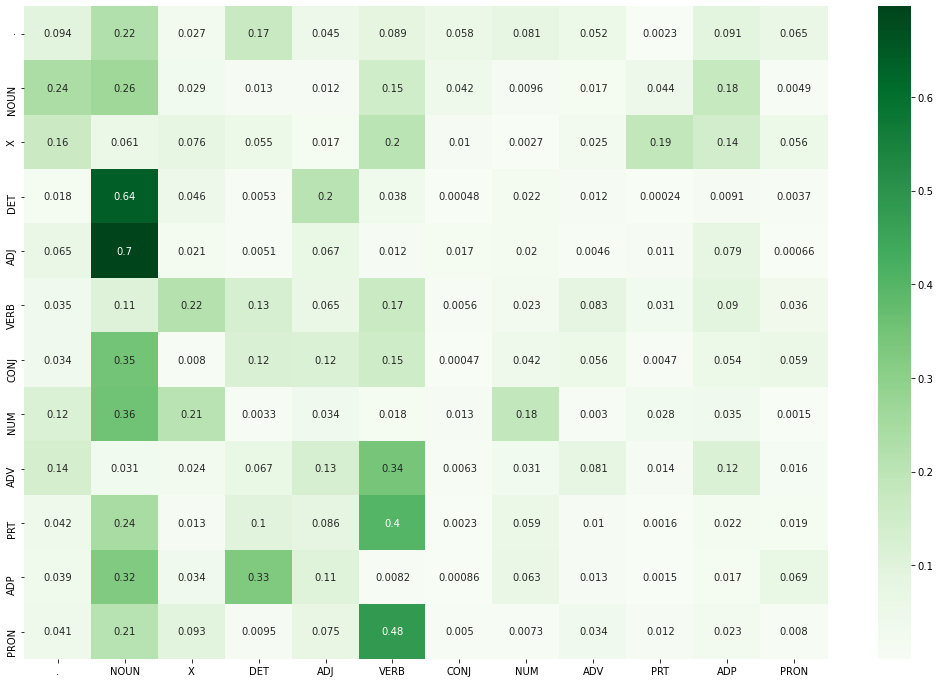

In [76]:
# Heatmap of tags matrix
# T(i, j) means P(tag j given tag i)

plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, cmap= 'Greens', annot=True)
plt.show()

The above heatmap clearly shows the frequent tags e.g.
 - Probability of Noun given previous tag as Adjective is highest, followed by probability of Noun given previous tag Determinant

#### 3. Apply vanilla Viterbi Algorithm

Let's now use the computed probabilities P(w/tag) and P(t2/t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(t2/t1) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list 'tag_assigned'. As we progress further in the list, we will use the previous tag and current tag to get transisition probability from tags_df dataframe.

Note: P(tag|start) = P(tag|'.') 

In [77]:
# Viterbi algorithm without any modifications

## Function name: Viterbi
##      Input parameters: 'words' 
##      Returns : list(zip(words, tag_assigned))= List of pairs of 'word' and 'the assigned tag to that word'


def Viterbi(words, train_bag = train_tagged_words):
    
    tag_assigned = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        ## Initialise list of probability column for a given word
        p = [] 
        
        for tag in T:
            ## Get the tansition probability from tags_df 
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[tag_assigned[-1], tag]
                
            # Compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        ## Maximum probability
        pmax = max(p)
        
        ## Assigning tag with maximum probability to the word
        tag_max = T[p.index(pmax)] 
        
        tag_assigned.append(tag_max)
        
    return list(zip(words, tag_assigned))


#### 4. Evaluating the vanilla Viterbi algorithm on Test dataset

Extract the Sentences and Words & tags from the TEST dataset 

In [78]:
## Extract the list of words and associated tags from test dataset

test_tagged_words = []
for sent in test_set:
    for tup in sent :
        test_tagged_words.append(tup) 

In [79]:
## Print first few words and tags
test_tagged_words[0:40]
len(test_tagged_words)

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.'),
 ('200', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('in', 'ADP'),
 ('secondary', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('under', 'ADP'),
 ('an', 'DET'),
 ('expanded', 'VERB'),
 ('trade', 'NOUN'),
 ('credit', 'NOUN'),
 ('insurance', 'NOUN'),
 ('program', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('total', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('Overseas', 'NOUN'),
 ('Private', 'NOUN'),
 ('Investment', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('are', 'VERB'),
 ('increased', 'VERB'),
 ('*-3', 'X'),
 ('by', 'ADP'),
 ('$', '.')]

5087

In [80]:
## Extract the list of words
test_tokens = []
for pair in test_tagged_words:
    test_tokens.append(pair[0])

In [81]:
test_tokens

['For',
 'the',
 'Agency',
 'for',
 'International',
 'Development',
 ',',
 'appropriators',
 'approved',
 '$',
 '200',
 'million',
 '*U*',
 'in',
 'secondary',
 'loan',
 'guarantees',
 'under',
 'an',
 'expanded',
 'trade',
 'credit',
 'insurance',
 'program',
 ',',
 'and',
 'total',
 'loan',
 'guarantees',
 'for',
 'the',
 'Overseas',
 'Private',
 'Investment',
 'Corp.',
 'are',
 'increased',
 '*-3',
 'by',
 '$',
 '40',
 'million',
 '*U*',
 'over',
 'fiscal',
 '1989',
 'as',
 'part',
 'of',
 'the',
 'same',
 'Poland',
 'package',
 '.',
 'The',
 'market',
 'is',
 'just',
 'becoming',
 'more',
 'efficient',
 '.',
 "''",
 'Moscow',
 'has',
 'settled',
 'pre-1917',
 'debts',
 'with',
 'other',
 'countries',
 'in',
 'recent',
 'years',
 'at',
 'less',
 'than',
 'face',
 'value',
 '.',
 '``',
 'Unemployment',
 'continues',
 'at',
 'a',
 'relatively',
 'low',
 'level',
 ',',
 '*',
 'providing',
 'a',
 'sense',
 'of',
 'job',
 'security',
 ',',
 'and',
 'a',
 'low',
 'inflation',
 'rate',
 '

In [82]:
import time
# Tag the test sentences
start = time.time()

## Call the Viterbi function written above to tag the words based on maximum probability
tagged_seq = Viterbi(test_tokens)

end = time.time()
time_execution = end-start

## Print the execution time for Viterbi alogorithm
time_execution

967.477712392807

In [83]:
## Print the Words and the Tags assigned to them 
tagged_seq

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.'),
 ('200', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('in', 'ADP'),
 ('secondary', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('under', 'ADP'),
 ('an', 'DET'),
 ('expanded', 'VERB'),
 ('trade', 'VERB'),
 ('credit', 'NOUN'),
 ('insurance', 'NOUN'),
 ('program', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('total', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('Overseas', '.'),
 ('Private', 'ADJ'),
 ('Investment', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('are', 'VERB'),
 ('increased', 'VERB'),
 ('*-3', 'X'),
 ('by', 'ADP'),
 ('$', '.'),
 ('40', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('over', 'ADP'),
 ('fiscal', 'ADJ'),
 ('1989', 'NUM'),
 ('as', 'ADP'),
 ('part', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('same', 'ADJ'),
 ('Poland', 'NOUN'),
 

#### Evaluate tagging accuracy of vanilla Viterbi

In [84]:
## Check the accuracy 
correct_tagged_words = [i for i, j in zip(tagged_seq, test_tagged_words) if i == j]

accuracy = len(correct_tagged_words)/len(tagged_seq)
accuracy

0.9138981718104974

In [87]:
## Get the words which are Incorrectly tagged
incorrect_tagged_cases = [[test_tagged_words[i-1],j] for i, j in enumerate(zip(tagged_seq, test_tagged_words)) if j[0]!=j[1]]


In [88]:
## Print the incorrect tagged words. 
## Each row shows the previous word + tag, word + tag assigned by Viterbi, word + original tag from test dataset

incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', '.'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', '.'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', '.'), ('Unemployment', 'NOUN'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', '.'), ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'), (('reasonably', '.'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('*-1', 'X'), (('Funded', '.'), ('Funded', 'VERB'))],
 [('from', 'ADP'), (('Tokio', '.'), ('Tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', '.'), ('protocols', 'NOUN'))],
 [('on', 'ADP'), (('preventative', '.'), ('preventative', 'ADJ'))],
 [('it', 'PRON'), (('existed', '.'), ('exi

As we see , all the Unknown words i.e. Words which are not present in Train dataset are incorrectly tagged with the **first** tag in Train dataset.

#### Testing Vanilla Viterbi on Sample sentences 

In [89]:
## Testing on the sample sentences given
## We will take 3 sample sentences and run the Viterbi algorithm on them and check if the words are tagged correctly

In [90]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
## Sample test sentence 1 
sentence_test1 = "Android is a mobile operating system developed by Google."
sentence_test1_words = word_tokenize(sentence_test1)
tagged_seq_test_sent1 = Viterbi(sentence_test1_words)

tagged_seq_test_sent1

[('Android', '.'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', '.'),
 ('.', '.')]

We can see above that 'Android' & 'Google' words are incorrectly tagged because they are unknown (not present in train Corpus)

In [92]:
## Sample test sentence 2
sentence_test2 = "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."
sentence_test2_words = word_tokenize(sentence_test2)
tagged_seq_test_sent2 = Viterbi(sentence_test2_words)

tagged_seq_test_sent2

[('The', 'DET'),
 ('2018', '.'),
 ('FIFA', '.'),
 ('World', 'NOUN'),
 ('Cup', '.'),
 ('is', 'VERB'),
 ('the', 'DET'),
 ('21st', '.'),
 ('FIFA', '.'),
 ('World', 'NOUN'),
 ('Cup', '.'),
 (',', '.'),
 ('an', 'DET'),
 ('international', 'ADJ'),
 ('football', 'NOUN'),
 ('tournament', '.'),
 ('contested', '.'),
 ('once', 'ADV'),
 ('every', 'DET'),
 ('four', 'NUM'),
 ('years', 'NOUN'),
 ('.', '.')]

We can see above that many words are incorrectly tagged because they are unknown (not present in train Corpus)

In [93]:
## Sample test sentence 3
sentence_test3 = "NASA invited social media users to experience the launch of ICESAT-2 Satellite."
sentence_test3_words = word_tokenize(sentence_test3)
tagged_seq_test_sent3 = Viterbi(sentence_test3_words)

tagged_seq_test_sent3

[('NASA', '.'),
 ('invited', '.'),
 ('social', 'ADJ'),
 ('media', 'NOUN'),
 ('users', 'NOUN'),
 ('to', 'PRT'),
 ('experience', 'NOUN'),
 ('the', 'DET'),
 ('launch', 'NOUN'),
 ('of', 'ADP'),
 ('ICESAT-2', '.'),
 ('Satellite', '.'),
 ('.', '.')]

We see that words 'NASA', 'invited', 'ICESAT-2', 'Satellite' being incorrectly tagged by the first tag in Train dataset

### Solve the problem of Unknown words -Technique 1 : Assign most frequent tag

#### Find out the Most frequently used tag in Train Corpus 

In [94]:
## Lets find out the most used tag in Train corpus
## Converting train_tagged_words list to dataframe for easier handling
df_train_tagged_words = pd.DataFrame(train_tagged_words, columns = ['word', 'tag'])

In [95]:
df_train_tagged_words.head()

,word,tag
0,Bank,NOUN
1,of,ADP
2,New,NOUN
3,England,NOUN
4,'s,PRT


In [96]:
## Get the count of words in train corpus corresponding to each tag 
df_train_tagged_words.groupby('tag')['word'].count().sort_values()

tag
CONJ     2131
PRON     2618
ADV      3010
PRT      3059
NUM      3363
ADJ      6077
X        6276
DET      8284
ADP      9345
.       11118
VERB    12885
NOUN    27423
Name: word, dtype: int64

We can see **NOUN** is the most frequently used tag in Train corpus. So we will assign the tag 'NOUN' to all the Unknown words i.e. words which do not exist in Train corpus

#### Modify the Viterbi algorithm 

In [97]:
## Assign the tag 'NOUN' to unknown words. (Noun being the most common tag in train corpus/dictionary.

## Viterbi algorithm for technique-1

## Function name: Viterbi_lexicon
##      Input parameters: 'words' 
##      Returns : list(zip(tagged_words, assigned_tags))= List of pairs of 'word' and 'the assigned tag to that word'


def Viterbi_lexicon(words, train_bag = train_tagged_words):
    
    ## Store the Words from train corpus in vocabulary V
    V = list(set([pair[0] for pair in train_bag]))
    
    ## Call the default Viterbi function and store the output in tagged_seq which is pair of word and POS tag assigned to it
    tagged_seq = Viterbi(words)
    
    tagged_words = [pair[0] for pair in tagged_seq]
    assigned_tags = [pair[1] for pair in tagged_seq]
    
    ## Assign the tag as 'NOUN' for the test words which are not present in train corpus
    for key, word in enumerate(tagged_words):
        if word not in V:
            assigned_tags[key] = 'NOUN'
            
    return list(zip(tagged_words, assigned_tags))

In [98]:

## Call the Viterbi_lexicon function written above to tag the words from Test dataset

start = time.time()

tagged_seq_lexicon = Viterbi_lexicon(test_tokens)

end = time.time()
time_execution = end-start

## Print the execution time for Viterbi alogorithm
time_execution

1106.51105260849

####  Comparing the tagging accuracy with vanilla Viterbi 

In [99]:
## Check the accuracy 
correct_tagged_words_lexicon = [i for i, j in zip(tagged_seq_lexicon, test_tagged_words) if i == j]

accuracy_lexicon = len(correct_tagged_words_lexicon)/len(tagged_seq_lexicon)
accuracy_lexicon

0.9400432474936111

We can see that the accuracy has improved to **94%** after assigning the most frequent tag (NOUN) to the Unknown words.

#### Testing Viterbi-Technique 1 on Sample sentences which were incorrectly tagged by original POS tagger 

We have earlier tokenized and tested below 3 sentences with default Viterbi algorithm

 - sentence_test1 = "Android is a mobile operating system developed by Google."
 - sentence_test2 = "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."
 - sentence_test3 = "NASA invited social media users to experience the launch of ICESAT-2 Satellite."
 
Lets test the same sentences by modified algorithm 'Viterbi_lexicon'


In [100]:
##"Android is a mobile operating system developed by Google."

tagged_seq_test_sent1 = Viterbi_lexicon(sentence_test1_words)

tagged_seq_test_sent1

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.')]

We see above that 'Android' and 'Google' are correctly tagged as NOUN

In [101]:
## "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."

tagged_seq_test_sent2 = Viterbi_lexicon(sentence_test2_words)

tagged_seq_test_sent2

[('The', 'DET'),
 ('2018', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('World', 'NOUN'),
 ('Cup', 'NOUN'),
 ('is', 'VERB'),
 ('the', 'DET'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('World', 'NOUN'),
 ('Cup', 'NOUN'),
 (',', '.'),
 ('an', 'DET'),
 ('international', 'ADJ'),
 ('football', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'NOUN'),
 ('once', 'ADV'),
 ('every', 'DET'),
 ('four', 'NUM'),
 ('years', 'NOUN'),
 ('.', '.')]


We can see that with approach of assigning most frequent tag the words :'FIFA', 'Cup', 'tournament' are correctly tagged as Nouns whereas words '2018', '21st', 'contested' are still incorrectly tagged

In [102]:
## "NASA invited social media users to experience the launch of ICESAT-2 Satellite."

tagged_seq_test_sent3 = Viterbi_lexicon(sentence_test3_words)

tagged_seq_test_sent3

[('NASA', 'NOUN'),
 ('invited', 'NOUN'),
 ('social', 'ADJ'),
 ('media', 'NOUN'),
 ('users', 'NOUN'),
 ('to', 'PRT'),
 ('experience', 'NOUN'),
 ('the', 'DET'),
 ('launch', 'NOUN'),
 ('of', 'ADP'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN'),
 ('.', '.')]

The words 'NASA', 'ICESAT-2' and 'Satellite' are correctly tagged as NOUN. Word 'invited' is incorrectly tagged. 

### Solve the problem of Unknown words -Technique 2 : Rule based algorithm

In this technique, we will implement rules to tag the different categories of unknown words with most appropriate tags.

In [103]:
## Words ending with 'ed' or 'ing' can be Verb , Noun or Adjective. Lets find out the most frequent tag for such words.

In [105]:
df_train_tagged_words['word_ending_with_ed_flag'] = df_train_tagged_words['word'].apply(lambda x:1 if x[-2:] == 'ed' else 0)

In [106]:
df_train_tagged_words[df_train_tagged_words['word_ending_with_ed_flag'] == 1].groupby('tag')['word'].count().sort_values()

tag
ADP        1
NUM        2
ADV       10
NOUN      70
ADJ      289
VERB    2655
Name: word, dtype: int64

In [107]:
## Identify most frequently occuring tag for Words ending with 'ing'

In [108]:
df_train_tagged_words['word_ending_with_ing_flag'] = df_train_tagged_words['word'].apply(lambda x:1 if x[-3:] == 'ing' else 0)

In [109]:
df_train_tagged_words[df_train_tagged_words['word_ending_with_ing_flag'] == 1].groupby('tag')['word'].count().sort_values()

tag
ADP       42
ADJ      176
NOUN     782
VERB    1380
Name: word, dtype: int64

As seen above, the most frequent tag for words ending with 'ed' or 'ing' are VERB

#### Modify the Viterbi algorithm 

We will write function with following Rules:
 - All words with All digits OR digits until the decimal point(second last letter) are tagged as Numbers (NUM)
 - Words with first letter OR all letters capitalized are tagged as NOUN
 - Words ending with 'ous' are tagged as adjectives ('ADJ'). 
 - Words ending with 'ed' or 'ing' are tagged as 'VERB' because thats the most used tag for such words in training corpus
 - Rest all words are tagged as 'NOUN' because thats the most used tag in training corpus.
 

In [110]:
## Write the modified Viterbi function to implement above Rules.

## Viterbi algorithm for technique-2

## Function name: Viterbi_rule_based
##      Input parameters: 'words' 
##      Returns : list(zip(tagged_words, assigned_tags))= List of pairs of 'word' and 'the assigned tag to that word'

def Viterbi_rule_based( words, train_bag = train_tagged_words):
    
    ## Store the Words from train corpus in vocabulary V
    V = list(set([pair[0] for pair in train_bag]))
    
    ## Call the default Viterbi function and store the output in tagged_seq which is pair of word and POS tag assigned to it
    tagged_seq = Viterbi(words)
        
    tagged_words = [pair[0] for pair in tagged_seq]
    assigned_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(tagged_words):
        if word not in V:
            
            ## Word is number (Integer or with decimal point which is at 2nd last position in dataset)
            if (word.isdigit() == True or word[:-2].isdigit() == True):
                assigned_tags[key] = 'NUM'
                
            ## All letters capitalised
            elif word.upper() == word:
                assigned_tags[key] = 'NOUN'
                
            ## First letter is capitalised:
            elif word[0].upper() == word[0]:
                assigned_tags[key] = 'NOUN' 
                
            ## Word ending with '-ous'
            elif word[-3:] == 'ous':
                assigned_tags[key] = 'ADJ'
  
            ## Word ending with '-ed'
            elif word[-2:] == 'ed':
                assigned_tags[key] = 'VERB'
                
            ## Word ending with '-ing'
            elif word[-3:] == 'ing':
                assigned_tags[key] = 'VERB'
                
            else: 
                assigned_tags[key] = 'NOUN'
    
    return list(zip(tagged_words, assigned_tags))

In [111]:

## Call the Viterbi_rule_based function written above to tag the words from Test dataset

start = time.time()

tagged_seq_rule_based = Viterbi_rule_based(test_tokens)

end = time.time()
time_execution = end-start

## Print the execution time for Viterbi alogorithm
time_execution

1839.2096104621887

#### Comparing the tagging accuracy with vanilla Viterbi 

In [112]:
## Check the accuracy 
correct_tagged_words_rule_based = [i for i, j in zip(tagged_seq_rule_based, test_tagged_words) if i == j]

accuracy_rule_based = len(correct_tagged_words_rule_based)/len(tagged_seq_rule_based)
accuracy_rule_based

0.952034597994889

As we see the accuracy has increased to **95%** after implementing different rules to tag the unknown words.

#### Testing Viterbi-Technique 2 on Sample sentences which were incorrectly tagged by original POS tagger 

In [113]:
sentence_test1 = "Android is a mobile operating system developed by Google."

tagged_seq_test_sent1 = Viterbi_rule_based(sentence_test1_words)

tagged_seq_test_sent1

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.')]

We see above that 'Android' and 'Google' are correctly tagged as NOUN

In [114]:
sentence_test2 = "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."

tagged_seq_test_sent2 = Viterbi_rule_based(sentence_test2_words)

tagged_seq_test_sent2

[('The', 'DET'),
 ('2018', 'NUM'),
 ('FIFA', 'NOUN'),
 ('World', 'NOUN'),
 ('Cup', 'NOUN'),
 ('is', 'VERB'),
 ('the', 'DET'),
 ('21st', 'NUM'),
 ('FIFA', 'NOUN'),
 ('World', 'NOUN'),
 ('Cup', 'NOUN'),
 (',', '.'),
 ('an', 'DET'),
 ('international', 'ADJ'),
 ('football', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('once', 'ADV'),
 ('every', 'DET'),
 ('four', 'NUM'),
 ('years', 'NOUN'),
 ('.', '.')]


We can see that with Rule-based alogorithm, words 'FIFA', 'Cup', 'tournament' are correctly tagged as NOUN as well as words '2018', '21st', 'contested' (which were not correctly tagged with technique-1) are also correctly tagged as NUM, NUM and VERB respectively. 

In [115]:
sentence_test3 = "NASA invited social media users to experience the launch of ICESAT-2 Satellite."

tagged_seq_test_sent3 = Viterbi_rule_based(sentence_test3_words)

tagged_seq_test_sent3

[('NASA', 'NOUN'),
 ('invited', 'VERB'),
 ('social', 'ADJ'),
 ('media', 'NOUN'),
 ('users', 'NOUN'),
 ('to', 'PRT'),
 ('experience', 'NOUN'),
 ('the', 'DET'),
 ('launch', 'NOUN'),
 ('of', 'ADP'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN'),
 ('.', '.')]

The words 'NASA', 'ICESAT-2' and 'Satellite' are correctly tagged as NOUN. Word 'invited' is also correctly tagged as VERB. 

### Solve the problem of Unknown words -Technique 3 : Non-zero Emission Probability 

For Unknown words, the Emission probability = 0 because Emission probabilty = number of times the term 'word' has been tagged as tag 'tag' divided by the number of times the tag 'tag' appeared in the corpus train dataset. In case of Unknown words, the numerator is zero and hence the Emission probability & State probability. 

So in case of Unknown words, we will apply Laplace smoothing to consider the Emission probabilty as very small value (0.0001) which will effectly return a non-zero State proability. 

#### Modify the Viterbi algorithm 

In [116]:
## Write the modified Viterbi function to implement laplace smoothing for Emission probabilities .

## Viterbi algorithm for technique-3

## Function name: Viterbi_probabilistic
##      Input parameters: 'words' 
##      Returns : list(zip(words, tag_assigned))= List of pairs of 'word' and 'the assigned tag to that word'

def Viterbi_probabilistic(words, train_bag = train_tagged_words):
    
    tag_assigned = []
    T = list(set([pair[1] for pair in train_bag]))
    V = list(set([pair[0] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        ## Initialise list of probability column for a given word
        p = [] 
        
        for tag in T:
            ## Get the tansition probability from tags_df 
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[tag_assigned[-1], tag]
                
            ## Compute emission and state probabilities. 
            ## If the word is not present in train corpus(vocabulary), assign the emission probability = 0.0001
            if word in V:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else :
                emission_p = 0.0001
                     
            state_probability = emission_p * transition_p                           
            p.append(state_probability)
        
        ## Maximum probability
        pmax = max(p)
        
        ## Assigning tag with maximum probability to the word
        tag_max = T[p.index(pmax)] 
        tag_assigned.append(tag_max)
        
    return list(zip(words, tag_assigned))


In [117]:
## Call the Viterbi_probabilistic function written above to tag the words from Test dataset

start = time.time()

tagged_seq_probabilistic = Viterbi_probabilistic(test_tokens)

end = time.time()
time_execution = end-start

## Print the execution time for Viterbi alogorithm
time_execution

1760.0363867282867

#### Comparing the tagging accuracy with vanilla Viterbi 

In [118]:
## Check the accuracy 
correct_tagged_words_probabilistic = [i for i, j in zip(tagged_seq_probabilistic, test_tagged_words) if i == j]

accuracy_probabilistic = len(correct_tagged_words_probabilistic)/len(tagged_seq_probabilistic)
accuracy_probabilistic

0.9388637703951248

As seen above, the accuracy has increased to **94%** after making emission probability non-zero for the unknown words.

#### Testing Viterbi-Technique 3 on Sample sentences which were incorrectly tagged by original POS tagger 

In [119]:
## "Android is a mobile operating system developed by Google."

tagged_seq_test_sent1 = Viterbi_probabilistic(sentence_test1_words)

tagged_seq_test_sent1

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.')]

As seen above, 'Android' is tagged correctly whereas 'Google' is incorrectly tagged as DET by making Emission proabability for Unknown words as non-zero 

In [120]:
## "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."

tagged_seq_test_sent2 = Viterbi_probabilistic(sentence_test2_words)

tagged_seq_test_sent2

[('The', 'DET'),
 ('2018', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('World', 'NOUN'),
 ('Cup', 'NOUN'),
 ('is', 'VERB'),
 ('the', 'DET'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('World', 'NOUN'),
 ('Cup', 'NOUN'),
 (',', '.'),
 ('an', 'DET'),
 ('international', 'ADJ'),
 ('football', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'NOUN'),
 ('once', 'ADV'),
 ('every', 'DET'),
 ('four', 'NUM'),
 ('years', 'NOUN'),
 ('.', '.')]

We can see that with approach of assigning most frequent tag the words :'FIFA', 'Cup', 'tournament' are correctly tagged as Nouns whereas words '2018', '21st', 'contested' are still incorrectly tagged

In [121]:
## "NASA invited social media users to experience the launch of ICESAT-2 Satellite."

tagged_seq_test_sent3 = Viterbi_probabilistic(sentence_test3_words)

tagged_seq_test_sent3

[('NASA', 'NOUN'),
 ('invited', 'NOUN'),
 ('social', 'ADJ'),
 ('media', 'NOUN'),
 ('users', 'NOUN'),
 ('to', 'PRT'),
 ('experience', 'NOUN'),
 ('the', 'DET'),
 ('launch', 'NOUN'),
 ('of', 'ADP'),
 ('ICESAT-2', 'DET'),
 ('Satellite', 'NOUN'),
 ('.', '.')]

The words 'NASA' and 'Satellite' are correctly tagged as NOUN. Word 'ICESAT-2' and 'invited' is incorrectly tagged. 

### Conclusion

All Techniques-1 , 2 and 3 improved the accuracy of vanilla Viterbi algorithm from 91% to 94%, 95%, 94% respectively.

Based on results of Accuracy of alogorithm and correctness of tagging of sample test sentences, we conclude that **`Technique 2-Rule-based approach`** to fix the incorrect tags of Unknown words outperform the other 2 techniques.

Between Technique 1-'Assign the most used tag(in train corpus)' and Technique 3-'Non-zero Emission Probability' : Accuracy of both techniques are almost same. But when it comes to tagging of sample test stentences, technique 1 performed better than technique 3.  